In [2]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()
import io

Saving endava_email_tickets_ML.csv to endava_email_tickets_ML.csv


In [3]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import matplotlib.pyplot as plt

In [4]:
tickets_df = pd.read_csv(io.BytesIO(uploaded['endava_email_tickets_ML.csv']))

In [5]:
tickets_df.shape

(48549, 9)

In [149]:
tickets_df.head()


,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [150]:
tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             47837 non-null  object
 1   body              48549 non-null  object
 2   ticket_type       48549 non-null  int64 
 3   category          48549 non-null  int64 
 4   sub_category1     48549 non-null  int64 
 5   sub_category2     48549 non-null  int64 
 6   business_service  48549 non-null  int64 
 7   urgency           48549 non-null  int64 
 8   impact            48549 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 3.3+ MB


In [151]:
tickets_df.category.value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64

In [152]:
tickets_df.ticket_type.value_counts()

1    34621
0    13928
Name: ticket_type, dtype: int64

In [153]:
tickets_df.impact.value_counts()

4    34621
3    13184
0      471
2      228
1       45
Name: impact, dtype: int64

In [6]:
#removing rows where ticket description is a null value or empty string.
filter = tickets_df["body"] != ""
tickets_df = tickets_df[filter]
tickets_df = tickets_df.dropna()

In [7]:
tickets_df.shape #actual rows were 48549

(47837, 9)

In [13]:
#droping subcategories and business_service details
#tickets_df=tickets_df.drop(['sub_category1', 'sub_category2', 'business_service','urgency'], axis = 1)

In [8]:
import re
def preprocess_text(s):
    # Removing punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', s)
    # Removing single character
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [84]:
# model for ticket type

X = []
sentences = list(tickets_df["body"])
for s in sentences:
    X.append(preprocess_text(s))

y = tickets_df[["ticket_type"]].values

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [160]:
print('Max sentence length: ', max([len(s) for s in X_train]))
print('Min sentence length: ', min([len(s) for s in X_train]))
print('Median sentence length: ', np.median([len(s) for s in X_train]))

Max sentence length:  7011
Min sentence length:  2
Median sentence length:  150.0


In [86]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 150

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [87]:
model = Sequential()
model.add(Embedding(20000, 100, input_length=150))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


In [88]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 100)          2000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 2,017,569
Trainable params: 2,017,569
Non-trainable params: 0
_________________________________________________________________
None


In [89]:

history = model.fit(X_train, y_train,
                    epochs=3,
                    validation_data=(X_test, y_test),
                    batch_size=128)

Epoch 1/3
262/262 [==============================] - 94s 350ms/step - loss: 0.5695 - acc: 0.7338 - val_loss: 0.1191 - val_acc: 0.9699
Epoch 2/3
262/262 [==============================] - 92s 352ms/step - loss: 0.1299 - acc: 0.9665 - val_loss: 0.1487 - val_acc: 0.9540
Epoch 3/3
262/262 [==============================] - 93s 354ms/step - loss: 0.1494 - acc: 0.9536 - val_loss: 0.1018 - val_acc: 0.9747


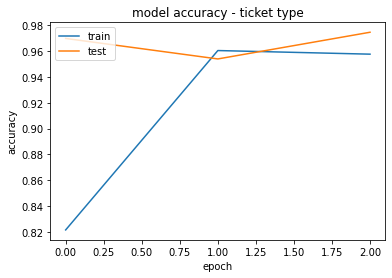

In [90]:
plt.title('model accuracy - ticket type')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


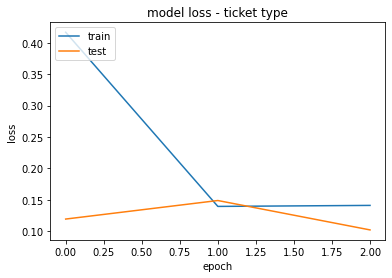

In [91]:
plt.title('model loss - ticket type')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [92]:
model.save("tickettype_model.h5")

In [93]:
from keras.models import load_model

In [96]:
tickettype_model = load_model('tickettype_model.h5')

pred = (tickettype_model.predict(X_test[0:5]) > 0.5).astype("int32")

print(pred)
print(y_test[0:5])

[[1]
 [1]
 [1]
 [0]
 [1]]
[[1]
 [1]
 [1]
 [0]
 [1]]


In [11]:
#Model for category

X = []
sentences = list(tickets_df["body"])
for s in sentences:
    X.append(preprocess_text(s))

y = tickets_df[["category"]]

In [14]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
id_labels = y.values.reshape(len(y), 1)
y_actual = encoder.fit_transform(id_labels)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_actual, test_size=0.30, random_state=0)

In [16]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 150

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [17]:
model = Sequential()
model.add(Embedding(20000, 100, input_length=150))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 13)                429       
Total params: 2,044,749
Trainable params: 2,044,749
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
y_test.shape

(14352, 13)

In [21]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    validation_data=(X_test, y_test),
                    batch_size=128)

Epoch 1/3
262/262 [==============================] - 126s 470ms/step - loss: 1.3544 - acc: 0.6791 - val_loss: 0.9429 - val_acc: 0.7035
Epoch 2/3
262/262 [==============================] - 122s 467ms/step - loss: 0.9513 - acc: 0.6983 - val_loss: 0.9374 - val_acc: 0.7035
Epoch 3/3
262/262 [==============================] - 123s 470ms/step - loss: 0.9514 - acc: 0.6998 - val_loss: 0.9362 - val_acc: 0.7035


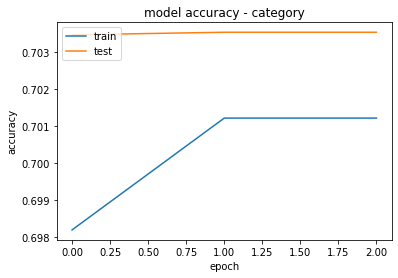

In [22]:
plt.title('model accuracy - category')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

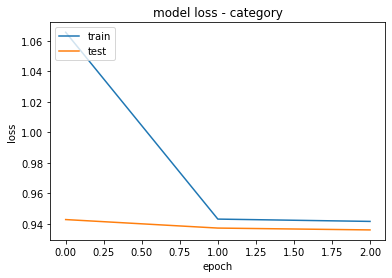

In [23]:
plt.title('model loss - category')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [24]:
model.save("category_model.h5")

In [39]:
category_model = load_model('category_model.h5')

pred = np.argmax(category_model.predict(X_test[0:5]),axis=-1)

print(pred)
print(encoder.inverse_transform(y_test[0:5]))

[4 4 4 4 4]
[[5]
 [4]
 [4]
 [4]
 [4]]


In [56]:
#Model for impact

X = []
sentences = list(tickets_df["body"])
for s in sentences:
    X.append(preprocess_text(s))

y = tickets_df[["impact"]]

In [57]:
encoder = OneHotEncoder(sparse=False)
id_labels = y.values.reshape(len(y), 1)
y_actual = encoder.fit_transform(id_labels)

In [58]:
y_actual[0]

array([0., 0., 0., 0., 1.])

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_actual, test_size=0.30, random_state=0)

In [60]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 150

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [61]:
model = Sequential()
model.add(Embedding(20000, 100, input_length=150))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [63]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    validation_data=(X_test, y_test),
                    batch_size=128)

Epoch 1/3
262/262 [==============================] - 130s 495ms/step - loss: 0.7172 - acc: 0.7110 - val_loss: 0.6677 - val_acc: 0.7213
Epoch 2/3
262/262 [==============================] - 128s 489ms/step - loss: 0.4232 - acc: 0.8586 - val_loss: 0.3286 - val_acc: 0.9091
Epoch 3/3
262/262 [==============================] - 128s 489ms/step - loss: 0.3137 - acc: 0.9175 - val_loss: 0.2605 - val_acc: 0.9383


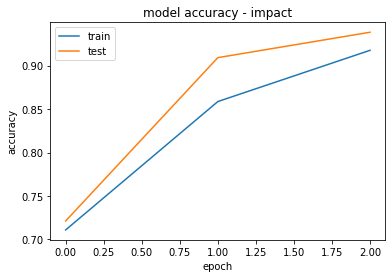

In [65]:
plt.title('model accuracy - impact')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

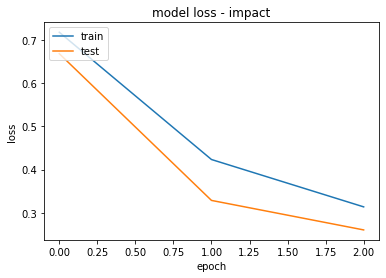

In [66]:
plt.title('model loss - impact')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [67]:
model.save("impact_model.h5")

In [68]:
impact_model = load_model('impact_model.h5')

pred = np.argmax(impact_model.predict(X_test[0:5]),axis=-1)

print(pred)
print(encoder.inverse_transform(y_test[0:5]))

[4 4 4 3 4]
[[4]
 [4]
 [4]
 [3]
 [4]]


In [74]:
#sentiment analysis
from textblob import TextBlob

def sentiment_analysis(ticket_text):
  score = TextBlob(ticket_text).sentiment.polarity
  sentiment = ""
  if score < 0:
    sentiment = "Negative"
  elif score == 0:
    sentiment = "Neutral"
  else:
    sentiment = "Positive"
    
  return sentiment

In [75]:
sentiment_analysis(X[0])

'Positive'

In [76]:
print(X[0])

icon dear please setup icon per icon engineers please let other details needed thanks lead


In [79]:
print(X[2000])

slider changer stick dear take slider changer stick pass presentation held today pm regards senior software developer


In [80]:
sentiment_analysis(X[2000])

'Neutral'